In [6]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.examples'

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# 計算需要的時間
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )
# 宣告類別
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):
    #初始化過程宣告影像大小與單色或是彩色
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D  = None   # discriminator function
        self.G  = None   # generator function
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same')) # 僅選一張 
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(learning_rate=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(learning_rate=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train # input_data.read_data_sets("mnist",one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])  # 雜訊 16 * 100
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]  # 256 height 25 width 25  channel 1
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100]) # 雜訊 256 * 100
            images_fake = self.generator.predict(noise)            # 256        25       25          1
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y) # ? check train_on_batch

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

In [4]:
# 主要程式碼
mnist_dcgan = MNIST_DCGAN()

timer = ElapsedTimer()
mnist_dcgan.train(train_steps=2500, batch_size=256, save_interval=500)
timer.elapsed_time()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

43: [D loss: 0.294788, acc: 0.931641]  [A loss: 0.721712, acc: 0.437500]
44: [D loss: 0.290279, acc: 0.939453]  [A loss: 1.003222, acc: 0.031250]
45: [D loss: 0.275353, acc: 0.949219]  [A loss: 1.323680, acc: 0.000000]
46: [D loss: 0.236960, acc: 0.992188]  [A loss: 1.427281, acc: 0.000000]
47: [D loss: 0.224958, acc: 0.992188]  [A loss: 1.666891, acc: 0.000000]
48: [D loss: 0.200539, acc: 1.000000]  [A loss: 1.895868, acc: 0.000000]
49: [D loss: 0.179197, acc: 1.000000]  [A loss: 2.215707, acc: 0.000000]
50: [D loss: 0.391477, acc: 0.988281]  [A loss: 0.001821, acc: 1.000000]
51: [D loss: 2.125029, acc: 0.500000]  [A loss: 0.488692, acc: 0.988281]
52: [D loss: 0.650145, acc: 0.501953]  [A loss: 0.736780, acc: 0.324219]
53: [D loss: 0.472106, acc: 0.519531]  [A loss: 0.851604, acc: 0.027344]
54: [D loss: 0.426450, acc: 0.531250]  [A loss: 0.940064, acc: 0.007812]
55: [D loss: 0.388923, acc: 0.607422]  [A loss: 0.964272, acc: 0.000000]
56: [D loss: 0.371224, acc: 0.652344]  [A loss: 0.9

155: [D loss: 0.131756, acc: 1.000000]  [A loss: 1.891184, acc: 0.000000]
156: [D loss: 0.122242, acc: 1.000000]  [A loss: 1.892618, acc: 0.000000]
157: [D loss: 0.137354, acc: 0.998047]  [A loss: 1.911818, acc: 0.000000]
158: [D loss: 0.122246, acc: 1.000000]  [A loss: 1.968072, acc: 0.000000]
159: [D loss: 0.114317, acc: 1.000000]  [A loss: 2.020777, acc: 0.000000]
160: [D loss: 0.108585, acc: 1.000000]  [A loss: 2.053393, acc: 0.000000]
161: [D loss: 0.104387, acc: 1.000000]  [A loss: 2.107417, acc: 0.000000]
162: [D loss: 0.097714, acc: 1.000000]  [A loss: 2.114417, acc: 0.000000]
163: [D loss: 0.097380, acc: 1.000000]  [A loss: 2.195476, acc: 0.000000]
164: [D loss: 0.090517, acc: 1.000000]  [A loss: 2.209995, acc: 0.000000]
165: [D loss: 0.087816, acc: 1.000000]  [A loss: 2.255244, acc: 0.000000]
166: [D loss: 0.125264, acc: 0.994141]  [A loss: 1.189933, acc: 0.000000]
167: [D loss: 0.424118, acc: 0.568359]  [A loss: 1.659808, acc: 0.000000]
168: [D loss: 0.183486, acc: 1.000000]

266: [D loss: 0.022443, acc: 1.000000]  [A loss: 5.289366, acc: 0.000000]
267: [D loss: 0.015429, acc: 1.000000]  [A loss: 5.021811, acc: 0.000000]
268: [D loss: 0.023681, acc: 1.000000]  [A loss: 5.684626, acc: 0.000000]
269: [D loss: 0.013916, acc: 1.000000]  [A loss: 5.299393, acc: 0.000000]
270: [D loss: 0.018333, acc: 1.000000]  [A loss: 5.578669, acc: 0.000000]
271: [D loss: 0.017711, acc: 1.000000]  [A loss: 5.664071, acc: 0.000000]
272: [D loss: 0.013644, acc: 1.000000]  [A loss: 5.576509, acc: 0.000000]
273: [D loss: 0.016550, acc: 1.000000]  [A loss: 5.846632, acc: 0.000000]
274: [D loss: 0.012717, acc: 1.000000]  [A loss: 5.607688, acc: 0.000000]
275: [D loss: 0.014059, acc: 1.000000]  [A loss: 5.866848, acc: 0.000000]
276: [D loss: 0.015447, acc: 1.000000]  [A loss: 6.040955, acc: 0.000000]
277: [D loss: 0.010934, acc: 1.000000]  [A loss: 5.807962, acc: 0.000000]
278: [D loss: 0.013622, acc: 1.000000]  [A loss: 6.150874, acc: 0.000000]
279: [D loss: 0.010144, acc: 1.000000]

377: [D loss: 0.008065, acc: 1.000000]  [A loss: 8.641257, acc: 0.000000]
378: [D loss: 0.003176, acc: 1.000000]  [A loss: 7.498077, acc: 0.000000]
379: [D loss: 0.009281, acc: 1.000000]  [A loss: 9.332339, acc: 0.000000]
380: [D loss: 0.001720, acc: 1.000000]  [A loss: 7.478601, acc: 0.000000]
381: [D loss: 0.008658, acc: 1.000000]  [A loss: 9.663807, acc: 0.000000]
382: [D loss: 0.001388, acc: 1.000000]  [A loss: 7.642492, acc: 0.000000]
383: [D loss: 0.010883, acc: 1.000000]  [A loss: 10.440415, acc: 0.000000]
384: [D loss: 0.000587, acc: 1.000000]  [A loss: 8.387589, acc: 0.000000]
385: [D loss: 0.004129, acc: 1.000000]  [A loss: 7.848990, acc: 0.000000]
386: [D loss: 0.003863, acc: 1.000000]  [A loss: 7.821162, acc: 0.000000]
387: [D loss: 0.007282, acc: 1.000000]  [A loss: 9.490973, acc: 0.000000]
388: [D loss: 0.001476, acc: 1.000000]  [A loss: 7.988703, acc: 0.000000]
389: [D loss: 0.004812, acc: 1.000000]  [A loss: 8.426567, acc: 0.000000]
390: [D loss: 0.002701, acc: 1.000000

488: [D loss: 0.088977, acc: 0.990234]  [A loss: 10.273580, acc: 0.000000]
489: [D loss: 0.001090, acc: 1.000000]  [A loss: 7.042914, acc: 0.000000]
490: [D loss: 0.022672, acc: 1.000000]  [A loss: 5.971097, acc: 0.000000]
491: [D loss: 0.067915, acc: 0.992188]  [A loss: 8.967599, acc: 0.000000]
492: [D loss: 0.003213, acc: 1.000000]  [A loss: 6.152103, acc: 0.000000]
493: [D loss: 0.056104, acc: 0.994141]  [A loss: 8.883858, acc: 0.000000]
494: [D loss: 0.004791, acc: 1.000000]  [A loss: 6.180004, acc: 0.000000]
495: [D loss: 0.061413, acc: 0.988281]  [A loss: 9.365829, acc: 0.000000]
496: [D loss: 0.002600, acc: 1.000000]  [A loss: 6.550815, acc: 0.000000]
497: [D loss: 0.032551, acc: 1.000000]  [A loss: 7.520021, acc: 0.000000]
498: [D loss: 0.014603, acc: 1.000000]  [A loss: 6.080368, acc: 0.000000]
499: [D loss: 0.064452, acc: 0.992188]  [A loss: 10.373699, acc: 0.000000]
500: [D loss: 0.001016, acc: 1.000000]  [A loss: 7.287186, acc: 0.000000]
501: [D loss: 0.014915, acc: 1.00000

599: [D loss: 0.000791, acc: 1.000000]  [A loss: 9.438848, acc: 0.000000]
600: [D loss: 0.002538, acc: 1.000000]  [A loss: 12.360266, acc: 0.000000]
601: [D loss: 0.000168, acc: 1.000000]  [A loss: 9.733289, acc: 0.000000]
602: [D loss: 0.002030, acc: 1.000000]  [A loss: 11.631780, acc: 0.000000]
603: [D loss: 0.000294, acc: 1.000000]  [A loss: 9.443897, acc: 0.000000]
604: [D loss: 0.002534, acc: 1.000000]  [A loss: 12.980536, acc: 0.000000]
605: [D loss: 0.000094, acc: 1.000000]  [A loss: 10.150692, acc: 0.000000]
606: [D loss: 0.001135, acc: 1.000000]  [A loss: 10.231359, acc: 0.000000]
607: [D loss: 0.000935, acc: 1.000000]  [A loss: 9.980546, acc: 0.000000]
608: [D loss: 0.001503, acc: 1.000000]  [A loss: 11.489986, acc: 0.000000]
609: [D loss: 0.000280, acc: 1.000000]  [A loss: 9.481456, acc: 0.000000]
610: [D loss: 0.002626, acc: 1.000000]  [A loss: 14.428032, acc: 0.000000]
611: [D loss: 0.000023, acc: 1.000000]  [A loss: 11.078442, acc: 0.000000]
612: [D loss: 0.000359, acc: 1

710: [D loss: 0.001337, acc: 1.000000]  [A loss: 9.194402, acc: 0.000000]
711: [D loss: 0.042544, acc: 0.982422]  [A loss: 10.328465, acc: 0.000000]
712: [D loss: 0.038290, acc: 0.988281]  [A loss: 10.501617, acc: 0.000000]
713: [D loss: 0.016078, acc: 0.996094]  [A loss: 7.949098, acc: 0.000000]
714: [D loss: 0.110905, acc: 0.953125]  [A loss: 16.883469, acc: 0.000000]
715: [D loss: 0.000103, acc: 1.000000]  [A loss: 12.153063, acc: 0.000000]
716: [D loss: 0.004226, acc: 1.000000]  [A loss: 8.397205, acc: 0.000000]
717: [D loss: 0.121854, acc: 0.945312]  [A loss: 18.270046, acc: 0.000000]
718: [D loss: 0.000020, acc: 1.000000]  [A loss: 13.500201, acc: 0.000000]
719: [D loss: 0.001325, acc: 1.000000]  [A loss: 9.161938, acc: 0.000000]
720: [D loss: 0.037739, acc: 0.986328]  [A loss: 10.745287, acc: 0.000000]
721: [D loss: 0.016526, acc: 0.998047]  [A loss: 9.256819, acc: 0.000000]
722: [D loss: 0.054519, acc: 0.982422]  [A loss: 13.050337, acc: 0.000000]
723: [D loss: 0.002204, acc: 1

820: [D loss: 0.000335, acc: 1.000000]  [A loss: 11.037468, acc: 0.000000]
821: [D loss: 0.012351, acc: 1.000000]  [A loss: 16.828749, acc: 0.000000]
822: [D loss: 0.000096, acc: 1.000000]  [A loss: 12.452412, acc: 0.000000]
823: [D loss: 0.006816, acc: 0.998047]  [A loss: 13.305059, acc: 0.000000]
824: [D loss: 0.001288, acc: 1.000000]  [A loss: 10.475723, acc: 0.000000]
825: [D loss: 0.018434, acc: 0.996094]  [A loss: 20.862968, acc: 0.000000]
826: [D loss: 0.037833, acc: 0.998047]  [A loss: 1.134427, acc: 0.539062]
827: [D loss: 1.537913, acc: 0.552734]  [A loss: 22.747698, acc: 0.000000]
828: [D loss: 0.000000, acc: 1.000000]  [A loss: 17.864122, acc: 0.000000]
829: [D loss: 0.000346, acc: 1.000000]  [A loss: 13.751581, acc: 0.000000]
830: [D loss: 0.000563, acc: 1.000000]  [A loss: 9.869197, acc: 0.000000]
831: [D loss: 0.021985, acc: 0.994141]  [A loss: 6.222032, acc: 0.000000]
832: [D loss: 0.262502, acc: 0.851562]  [A loss: 12.790374, acc: 0.000000]
833: [D loss: 0.003304, acc:

930: [D loss: 0.000294, acc: 1.000000]  [A loss: 12.151468, acc: 0.000000]
931: [D loss: 0.018118, acc: 0.996094]  [A loss: 9.233369, acc: 0.000000]
932: [D loss: 0.071488, acc: 0.978516]  [A loss: 13.400763, acc: 0.000000]
933: [D loss: 0.001979, acc: 1.000000]  [A loss: 8.468339, acc: 0.000000]
934: [D loss: 0.263895, acc: 0.878906]  [A loss: 24.538460, acc: 0.000000]
935: [D loss: 0.000000, acc: 1.000000]  [A loss: 19.129969, acc: 0.000000]
936: [D loss: 0.000097, acc: 1.000000]  [A loss: 13.446802, acc: 0.000000]
937: [D loss: 0.005485, acc: 0.998047]  [A loss: 8.621315, acc: 0.000000]
938: [D loss: 0.120164, acc: 0.953125]  [A loss: 17.291836, acc: 0.000000]
939: [D loss: 0.000813, acc: 1.000000]  [A loss: 11.509350, acc: 0.000000]
940: [D loss: 0.024285, acc: 0.992188]  [A loss: 9.791584, acc: 0.000000]
941: [D loss: 0.109812, acc: 0.955078]  [A loss: 17.363451, acc: 0.000000]
942: [D loss: 0.000759, acc: 1.000000]  [A loss: 12.028142, acc: 0.000000]
943: [D loss: 0.014178, acc: 

1039: [D loss: 0.079719, acc: 0.966797]  [A loss: 11.794467, acc: 0.000000]
1040: [D loss: 0.027496, acc: 0.986328]  [A loss: 9.116865, acc: 0.000000]
1041: [D loss: 0.128223, acc: 0.937500]  [A loss: 15.295588, acc: 0.000000]
1042: [D loss: 0.000820, acc: 1.000000]  [A loss: 10.470009, acc: 0.000000]
1043: [D loss: 0.063489, acc: 0.980469]  [A loss: 11.604467, acc: 0.000000]
1044: [D loss: 0.026002, acc: 0.994141]  [A loss: 9.370226, acc: 0.000000]
1045: [D loss: 0.105209, acc: 0.951172]  [A loss: 15.801812, acc: 0.000000]
1046: [D loss: 0.000620, acc: 1.000000]  [A loss: 10.505258, acc: 0.000000]
1047: [D loss: 0.079036, acc: 0.966797]  [A loss: 14.511698, acc: 0.000000]
1048: [D loss: 0.006488, acc: 1.000000]  [A loss: 9.331696, acc: 0.000000]
1049: [D loss: 0.139009, acc: 0.941406]  [A loss: 18.351616, acc: 0.000000]
1050: [D loss: 0.000043, acc: 1.000000]  [A loss: 12.669333, acc: 0.000000]
1051: [D loss: 0.008474, acc: 1.000000]  [A loss: 8.748065, acc: 0.003906]
1052: [D loss: 0

1147: [D loss: 0.052946, acc: 0.998047]  [A loss: 6.582048, acc: 0.011719]
1148: [D loss: 0.868560, acc: 0.724609]  [A loss: 34.120255, acc: 0.000000]
1149: [D loss: 0.000000, acc: 1.000000]  [A loss: 27.138466, acc: 0.000000]
1150: [D loss: 0.000001, acc: 1.000000]  [A loss: 20.749828, acc: 0.000000]
1151: [D loss: 0.000060, acc: 1.000000]  [A loss: 14.556095, acc: 0.000000]
1152: [D loss: 0.014112, acc: 0.996094]  [A loss: 9.733469, acc: 0.007812]
1153: [D loss: 0.298883, acc: 0.878906]  [A loss: 21.313389, acc: 0.000000]
1154: [D loss: 0.000087, acc: 1.000000]  [A loss: 14.258072, acc: 0.000000]
1155: [D loss: 0.023896, acc: 0.990234]  [A loss: 10.285031, acc: 0.000000]
1156: [D loss: 0.206712, acc: 0.910156]  [A loss: 20.621759, acc: 0.000000]
1157: [D loss: 0.000377, acc: 1.000000]  [A loss: 13.722221, acc: 0.000000]
1158: [D loss: 0.027020, acc: 0.990234]  [A loss: 10.365414, acc: 0.003906]
1159: [D loss: 0.247466, acc: 0.900391]  [A loss: 22.223755, acc: 0.000000]
1160: [D loss:

1255: [D loss: 0.227679, acc: 0.908203]  [A loss: 25.004076, acc: 0.000000]
1256: [D loss: 0.000002, acc: 1.000000]  [A loss: 18.191608, acc: 0.000000]
1257: [D loss: 0.004501, acc: 1.000000]  [A loss: 11.348503, acc: 0.003906]
1258: [D loss: 0.185590, acc: 0.921875]  [A loss: 24.871803, acc: 0.000000]
1259: [D loss: 0.000005, acc: 1.000000]  [A loss: 17.544067, acc: 0.000000]
1260: [D loss: 0.011962, acc: 0.994141]  [A loss: 12.328960, acc: 0.000000]
1261: [D loss: 0.119581, acc: 0.951172]  [A loss: 19.250578, acc: 0.000000]
1262: [D loss: 0.001753, acc: 1.000000]  [A loss: 12.302264, acc: 0.000000]
1263: [D loss: 0.137230, acc: 0.953125]  [A loss: 21.572155, acc: 0.000000]
1264: [D loss: 0.002869, acc: 0.998047]  [A loss: 14.312865, acc: 0.000000]
1265: [D loss: 0.069180, acc: 0.976562]  [A loss: 15.228675, acc: 0.000000]
1266: [D loss: 0.040046, acc: 0.980469]  [A loss: 13.796684, acc: 0.000000]
1267: [D loss: 0.065033, acc: 0.982422]  [A loss: 15.147954, acc: 0.000000]
1268: [D los

1363: [D loss: 0.051654, acc: 0.980469]  [A loss: 22.399792, acc: 0.000000]
1364: [D loss: 0.000230, acc: 1.000000]  [A loss: 14.940405, acc: 0.003906]
1365: [D loss: 0.115585, acc: 0.958984]  [A loss: 31.949604, acc: 0.000000]
1366: [D loss: 0.000000, acc: 1.000000]  [A loss: 24.030144, acc: 0.000000]
1367: [D loss: 0.000203, acc: 1.000000]  [A loss: 16.151531, acc: 0.000000]
1368: [D loss: 0.052647, acc: 0.980469]  [A loss: 25.039532, acc: 0.000000]
1369: [D loss: 0.000055, acc: 1.000000]  [A loss: 18.101475, acc: 0.003906]
1370: [D loss: 0.028101, acc: 0.994141]  [A loss: 19.525204, acc: 0.000000]
1371: [D loss: 0.009176, acc: 0.998047]  [A loss: 15.721610, acc: 0.000000]
1372: [D loss: 0.073352, acc: 0.978516]  [A loss: 26.052849, acc: 0.000000]
1373: [D loss: 0.000050, acc: 1.000000]  [A loss: 18.509771, acc: 0.000000]
1374: [D loss: 0.024845, acc: 0.990234]  [A loss: 18.957645, acc: 0.000000]
1375: [D loss: 0.006159, acc: 0.998047]  [A loss: 15.436342, acc: 0.000000]
1376: [D los

1471: [D loss: 0.124281, acc: 0.949219]  [A loss: 14.795207, acc: 0.000000]
1472: [D loss: 0.087825, acc: 0.964844]  [A loss: 12.545629, acc: 0.000000]
1473: [D loss: 0.296314, acc: 0.886719]  [A loss: 22.028988, acc: 0.000000]
1474: [D loss: 0.003895, acc: 1.000000]  [A loss: 14.111362, acc: 0.000000]
1475: [D loss: 0.156538, acc: 0.935547]  [A loss: 17.094467, acc: 0.000000]
1476: [D loss: 0.052940, acc: 0.974609]  [A loss: 13.449598, acc: 0.000000]
1477: [D loss: 0.217925, acc: 0.916016]  [A loss: 20.246552, acc: 0.000000]
1478: [D loss: 0.001233, acc: 1.000000]  [A loss: 12.690530, acc: 0.003906]
1479: [D loss: 0.297434, acc: 0.902344]  [A loss: 23.611086, acc: 0.000000]
1480: [D loss: 0.000750, acc: 1.000000]  [A loss: 15.207762, acc: 0.003906]
1481: [D loss: 0.074768, acc: 0.970703]  [A loss: 14.149303, acc: 0.000000]
1482: [D loss: 0.143594, acc: 0.931641]  [A loss: 19.162577, acc: 0.000000]
1483: [D loss: 0.013039, acc: 0.996094]  [A loss: 11.481997, acc: 0.000000]
1484: [D los

1579: [D loss: 0.000003, acc: 1.000000]  [A loss: 19.559301, acc: 0.000000]
1580: [D loss: 0.000868, acc: 1.000000]  [A loss: 12.297190, acc: 0.000000]
1581: [D loss: 0.127872, acc: 0.951172]  [A loss: 37.405170, acc: 0.000000]
1582: [D loss: 0.000000, acc: 1.000000]  [A loss: 28.653534, acc: 0.000000]
1583: [D loss: 0.000002, acc: 1.000000]  [A loss: 21.398411, acc: 0.000000]
1584: [D loss: 0.000289, acc: 1.000000]  [A loss: 14.170635, acc: 0.000000]
1585: [D loss: 0.068352, acc: 0.968750]  [A loss: 31.076477, acc: 0.000000]
1586: [D loss: 0.000003, acc: 1.000000]  [A loss: 23.034842, acc: 0.000000]
1587: [D loss: 0.000051, acc: 1.000000]  [A loss: 15.418045, acc: 0.000000]
1588: [D loss: 0.028118, acc: 0.984375]  [A loss: 19.606949, acc: 0.000000]
1589: [D loss: 0.001720, acc: 1.000000]  [A loss: 13.271998, acc: 0.000000]
1590: [D loss: 0.082116, acc: 0.970703]  [A loss: 30.123919, acc: 0.000000]
1591: [D loss: 0.000000, acc: 1.000000]  [A loss: 22.509758, acc: 0.000000]
1592: [D los

1687: [D loss: 0.000000, acc: 1.000000]  [A loss: 22.870422, acc: 0.000000]
1688: [D loss: 0.000244, acc: 1.000000]  [A loss: 14.972463, acc: 0.000000]
1689: [D loss: 0.025155, acc: 0.992188]  [A loss: 18.622332, acc: 0.000000]
1690: [D loss: 0.000814, acc: 1.000000]  [A loss: 11.663587, acc: 0.000000]
1691: [D loss: 0.132937, acc: 0.951172]  [A loss: 37.354794, acc: 0.000000]
1692: [D loss: 0.000000, acc: 1.000000]  [A loss: 29.766941, acc: 0.000000]
1693: [D loss: 0.000003, acc: 1.000000]  [A loss: 22.428072, acc: 0.000000]
1694: [D loss: 0.000078, acc: 1.000000]  [A loss: 15.083764, acc: 0.000000]
1695: [D loss: 0.014639, acc: 0.998047]  [A loss: 14.095898, acc: 0.000000]
1696: [D loss: 0.039620, acc: 0.982422]  [A loss: 22.878395, acc: 0.000000]
1697: [D loss: 0.000182, acc: 1.000000]  [A loss: 15.253141, acc: 0.000000]
1698: [D loss: 0.025973, acc: 0.988281]  [A loss: 19.443640, acc: 0.000000]
1699: [D loss: 0.001039, acc: 1.000000]  [A loss: 12.887115, acc: 0.000000]
1700: [D los

1795: [D loss: 0.000000, acc: 1.000000]  [A loss: 31.880478, acc: 0.000000]
1796: [D loss: 0.000076, acc: 1.000000]  [A loss: 22.096859, acc: 0.000000]
1797: [D loss: 0.032437, acc: 0.982422]  [A loss: 35.437817, acc: 0.000000]
1798: [D loss: 0.000006, acc: 1.000000]  [A loss: 24.256622, acc: 0.000000]
1799: [D loss: 0.010673, acc: 0.996094]  [A loss: 23.607365, acc: 0.000000]
1800: [D loss: 0.038668, acc: 0.988281]  [A loss: 33.833000, acc: 0.000000]
1801: [D loss: 0.000014, acc: 1.000000]  [A loss: 23.334888, acc: 0.000000]
1802: [D loss: 0.018826, acc: 0.990234]  [A loss: 31.686161, acc: 0.000000]
1803: [D loss: 0.000022, acc: 1.000000]  [A loss: 21.439009, acc: 0.003906]
1804: [D loss: 0.074177, acc: 0.972656]  [A loss: 51.985687, acc: 0.000000]
1805: [D loss: 0.000000, acc: 1.000000]  [A loss: 42.028542, acc: 0.000000]
1806: [D loss: 0.000000, acc: 1.000000]  [A loss: 31.760611, acc: 0.000000]
1807: [D loss: 0.000279, acc: 1.000000]  [A loss: 22.002420, acc: 0.000000]
1808: [D los

1903: [D loss: 0.482866, acc: 0.869141]  [A loss: 34.780685, acc: 0.000000]
1904: [D loss: 0.000016, acc: 1.000000]  [A loss: 23.504908, acc: 0.000000]
1905: [D loss: 0.060530, acc: 0.984375]  [A loss: 16.217655, acc: 0.007812]
1906: [D loss: 0.373125, acc: 0.908203]  [A loss: 31.406738, acc: 0.000000]
1907: [D loss: 0.000594, acc: 1.000000]  [A loss: 20.047461, acc: 0.000000]
1908: [D loss: 0.138810, acc: 0.972656]  [A loss: 20.499676, acc: 0.000000]
1909: [D loss: 0.177433, acc: 0.949219]  [A loss: 24.831783, acc: 0.000000]
1910: [D loss: 0.008466, acc: 0.996094]  [A loss: 15.191251, acc: 0.019531]
1911: [D loss: 0.753223, acc: 0.828125]  [A loss: 48.421219, acc: 0.000000]
1912: [D loss: 0.000000, acc: 1.000000]  [A loss: 37.729286, acc: 0.000000]
1913: [D loss: 0.000001, acc: 1.000000]  [A loss: 26.136135, acc: 0.000000]
1914: [D loss: 0.006592, acc: 1.000000]  [A loss: 15.817111, acc: 0.003906]
1915: [D loss: 0.501414, acc: 0.882812]  [A loss: 39.110428, acc: 0.000000]
1916: [D los

2011: [D loss: 0.136654, acc: 0.964844]  [A loss: 34.718723, acc: 0.000000]
2012: [D loss: 0.010482, acc: 0.996094]  [A loss: 24.002804, acc: 0.000000]
2013: [D loss: 0.182867, acc: 0.957031]  [A loss: 42.166664, acc: 0.000000]
2014: [D loss: 0.000000, acc: 1.000000]  [A loss: 28.387213, acc: 0.000000]
2015: [D loss: 0.026838, acc: 0.988281]  [A loss: 22.454000, acc: 0.007812]
2016: [D loss: 0.311240, acc: 0.933594]  [A loss: 55.119617, acc: 0.000000]
2017: [D loss: 0.000001, acc: 1.000000]  [A loss: 41.852894, acc: 0.000000]
2018: [D loss: 0.000678, acc: 1.000000]  [A loss: 28.269249, acc: 0.000000]
2019: [D loss: 0.039096, acc: 0.986328]  [A loss: 26.411850, acc: 0.000000]
2020: [D loss: 0.073498, acc: 0.976562]  [A loss: 32.875572, acc: 0.000000]
2021: [D loss: 0.019137, acc: 0.996094]  [A loss: 24.992622, acc: 0.000000]
2022: [D loss: 0.159489, acc: 0.953125]  [A loss: 48.384296, acc: 0.000000]
2023: [D loss: 0.000001, acc: 1.000000]  [A loss: 35.224342, acc: 0.000000]
2024: [D los

2119: [D loss: 0.022209, acc: 0.996094]  [A loss: 28.520020, acc: 0.000000]
2120: [D loss: 0.108347, acc: 0.980469]  [A loss: 54.141357, acc: 0.000000]
2121: [D loss: 0.000000, acc: 1.000000]  [A loss: 40.880653, acc: 0.000000]
2122: [D loss: 0.004035, acc: 0.998047]  [A loss: 31.277411, acc: 0.000000]
2123: [D loss: 0.083397, acc: 0.980469]  [A loss: 57.624718, acc: 0.000000]
2124: [D loss: 0.000000, acc: 1.000000]  [A loss: 44.024673, acc: 0.000000]
2125: [D loss: 0.000079, acc: 1.000000]  [A loss: 30.071981, acc: 0.007812]
2126: [D loss: 0.046120, acc: 0.982422]  [A loss: 50.880424, acc: 0.000000]
2127: [D loss: 0.121024, acc: 0.998047]  [A loss: 21.891201, acc: 0.019531]
2128: [D loss: 0.987465, acc: 0.853516]  [A loss: 80.239807, acc: 0.000000]
2129: [D loss: 0.000000, acc: 1.000000]  [A loss: 63.915211, acc: 0.000000]
2130: [D loss: 0.000000, acc: 1.000000]  [A loss: 46.692158, acc: 0.000000]
2131: [D loss: 0.017200, acc: 0.998047]  [A loss: 34.578682, acc: 0.000000]
2132: [D los

2227: [D loss: 0.261167, acc: 0.962891]  [A loss: 65.357674, acc: 0.000000]
2228: [D loss: 0.000000, acc: 1.000000]  [A loss: 47.642254, acc: 0.000000]
2229: [D loss: 0.077850, acc: 0.986328]  [A loss: 45.733463, acc: 0.000000]
2230: [D loss: 0.161008, acc: 0.974609]  [A loss: 58.379444, acc: 0.003906]
2231: [D loss: 0.015886, acc: 0.998047]  [A loss: 40.861240, acc: 0.003906]
2232: [D loss: 0.222196, acc: 0.968750]  [A loss: 66.540283, acc: 0.000000]
2233: [D loss: 0.000173, acc: 1.000000]  [A loss: 46.283012, acc: 0.000000]
2234: [D loss: 0.059946, acc: 0.988281]  [A loss: 46.356266, acc: 0.000000]
2235: [D loss: 0.140006, acc: 0.976562]  [A loss: 63.956520, acc: 0.000000]
2236: [D loss: 0.000019, acc: 1.000000]  [A loss: 44.612080, acc: 0.000000]
2237: [D loss: 0.159603, acc: 0.960938]  [A loss: 82.557266, acc: 0.000000]
2238: [D loss: 0.000000, acc: 1.000000]  [A loss: 60.937256, acc: 0.000000]
2239: [D loss: 0.003693, acc: 0.998047]  [A loss: 46.235088, acc: 0.000000]
2240: [D los

2335: [D loss: 0.103019, acc: 0.986328]  [A loss: 91.902931, acc: 0.000000]
2336: [D loss: 0.005091, acc: 0.996094]  [A loss: 78.589584, acc: 0.003906]
2337: [D loss: 0.140719, acc: 0.986328]  [A loss: 105.026825, acc: 0.000000]
2338: [D loss: 0.000006, acc: 1.000000]  [A loss: 80.162064, acc: 0.000000]
2339: [D loss: 0.045878, acc: 0.992188]  [A loss: 86.527969, acc: 0.000000]
2340: [D loss: 0.083639, acc: 0.990234]  [A loss: 95.857330, acc: 0.000000]
2341: [D loss: 0.000000, acc: 1.000000]  [A loss: 71.638458, acc: 0.003906]
2342: [D loss: 0.141691, acc: 0.986328]  [A loss: 109.836990, acc: 0.000000]
2343: [D loss: 0.000376, acc: 1.000000]  [A loss: 83.697174, acc: 0.000000]
2344: [D loss: 0.004454, acc: 0.998047]  [A loss: 68.711365, acc: 0.003906]
2345: [D loss: 0.245172, acc: 0.978516]  [A loss: 131.296600, acc: 0.000000]
2346: [D loss: 0.000001, acc: 1.000000]  [A loss: 104.392189, acc: 0.000000]
2347: [D loss: 0.000001, acc: 1.000000]  [A loss: 77.954765, acc: 0.003906]
2348: [D

2443: [D loss: 0.570141, acc: 0.968750]  [A loss: 77.323364, acc: 0.007812]
2444: [D loss: 4.051011, acc: 0.980469]  [A loss: 33.501167, acc: 0.121094]
2445: [D loss: 6.112068, acc: 0.751953]  [A loss: 150.741196, acc: 0.000000]
2446: [D loss: 0.000000, acc: 1.000000]  [A loss: 116.540314, acc: 0.000000]
2447: [D loss: 0.034145, acc: 0.996094]  [A loss: 79.282806, acc: 0.003906]
2448: [D loss: 0.182438, acc: 0.976562]  [A loss: 60.904667, acc: 0.015625]
2449: [D loss: 0.955272, acc: 0.935547]  [A loss: 72.455048, acc: 0.007812]
2450: [D loss: 0.391875, acc: 0.968750]  [A loss: 65.795380, acc: 0.007812]
2451: [D loss: 1.369864, acc: 0.914062]  [A loss: 91.114189, acc: 0.000000]
2452: [D loss: 0.266433, acc: 0.982422]  [A loss: 74.535278, acc: 0.000000]
2453: [D loss: 0.508980, acc: 0.962891]  [A loss: 69.435623, acc: 0.015625]
2454: [D loss: 1.490142, acc: 0.916016]  [A loss: 104.175285, acc: 0.000000]
2455: [D loss: 0.042377, acc: 0.994141]  [A loss: 75.230804, acc: 0.000000]
2456: [D 

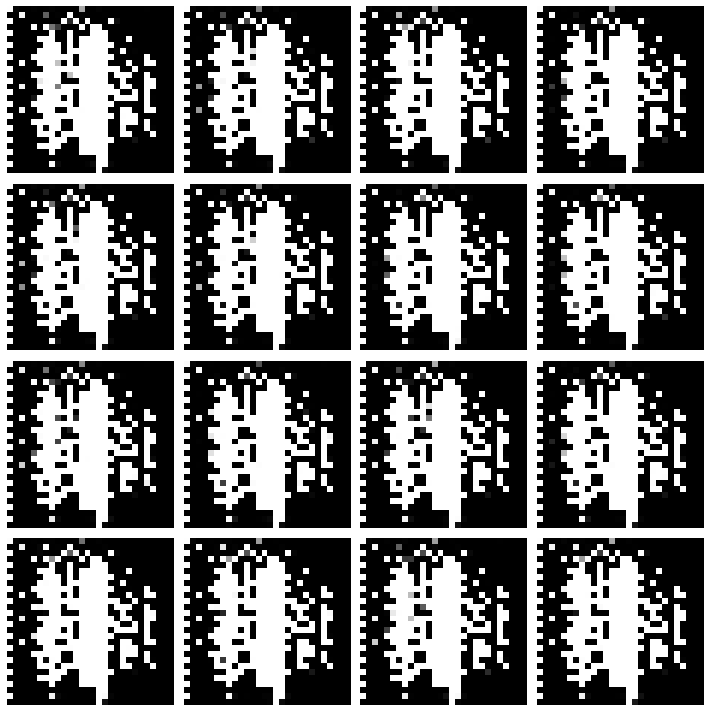

In [5]:
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)